In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# long_crps = pd.read_csv("./exp_results/long_crps.csv")
long_crps = pd.read_csv("./exp_results/update_long_crps.csv")
short_crps = pd.read_csv("./exp_results/short_crps.csv",index_col='Model')
# long_nmae = pd.read_csv("./exp_results/long_nmae.csv")
long_nmae = pd.read_csv("./exp_results/update_long_nmae.csv")
short_nmae = pd.read_csv("./exp_results/short_nmae.csv",index_col='Model')
data_char = pd.read_csv("./exp_results/data_char.csv",index_col='Data Characteristic')
sns.set(font_scale=2)

custom_palette = {
    "point": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
    "prob": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
}

In [3]:
type_dict = {}

for model in short_crps.index:
    if model in ['N-HiTS','iTransformer','NLinear','DLinear', 'PatchTST','TimesNet']:
        type = 'point'
    else:
        type = 'prob'

    type_dict.update({model: type})

auto_dict = {}

for model in ['iTransformer', 'DLinear','PatchTST',	'GRU NVP','TimeGrad','CSDI','GRU']:
    if model in ['GRU NVP','TimeGrad','GRU']:
        type = 'AR'
    else:
        type = 'NAR'

    auto_dict.update({model: type})

arch_dict = {}

for model in ['iTransformer','DLinear','PatchTST',	'GRU NVP','TimeGrad','CSDI']:
    if model in ['iTransformer','DLinear','PatchTST','CSDI']:
        type = 'customized'
    else:
        type = 'general'

    arch_dict.update({model: type})

# distribution correlation analysis

In [4]:
data_char

,Exchange-S,Solar-S,Electricity-S,Traffic-S,Wikipedia-S,ETTm1-L,ETTm2-L,ETTh1-L,ETTh2-L,Electricity-L,Traffic-L,Weather-L,Exchange-L,ILI-L
Data Characteristic,,,,,,,,,,,,,,
Trend,0.9982,0.1688,0.6443,0.2880,0.5253,0.9462,0.9770,0.7728,0.9412,0.6476,0.1632,0.9612,0.9978,0.5438
Seasonality,0.1256,0.8592,0.8323,0.6656,0.2234,0.0105,0.0612,0.4772,0.3608,0.8344,0.6798,0.2657,0.1349,0.6075
JS Div.,0.2967,0.5004,0.3579,0.2991,0.2751,0.0833,0.1701,0.0719,0.1422,0.1533,0.1378,0.1727,0.1082,0.1112


### Long-term

In [5]:
long_nmae.replace('-', np.nan, inplace=True)
long_nmae = long_nmae.apply(pd.to_numeric, errors='ignore')

long_crps.replace('-', np.nan, inplace=True)
long_crps = long_crps.apply(pd.to_numeric, errors='ignore')

# df_norm = long_nmae[['iTransformer', 'PatchTST', 'DLinear', 'Autoformer', 'TimeGrad', 'CSDI', 'GRU NVP']].apply(lambda x: (x) / x.std(ddof=0), axis=1)
df_norm = long_nmae[['iTransformer', 'PatchTST', 'DLinear', 'Autoformer', 'TimeGrad', 'CSDI', 'GRU NVP', 'GRU']]

# df_norm = long_nmae[['iTransformer','DLinear','PatchTST','GRU NVP','TimeGrad']].T.apply(lambda x: (x) / (np.std(x))).T
# df_norm = long_nmae[['iTransformer','DLinear','PatchTST','GRU NVP','TimeGrad']].apply(lambda x: (x) / (np.nanstd(x)) )
crps=[]
nmae=[]
models=[]
type=[]
datasets = []
pred_len = []
js_div = []
norm_nmae = []
dataset_set = []


dataset_indi = []
data_js = []
y = []


for dataset in data_char.columns:
    dataset_indi.append(dataset)
    data_js.append(data_char.loc['JS Div.'][dataset])
    y.append(1.05)

dataset_df = {'Dataset': dataset_indi, 'JS Div.': data_js, 'CRPS': y}
dataset_df = pd.DataFrame(dataset_df)

for model in ['GRU NVP','TimeGrad','CSDI','DLinear','iTransformer','PatchTST']:
    for idx in long_crps.index:
        # if long_crps['Model'][idx] in ['ETTm2','ILI']:long_crps[model][idx]
        # if long_crps['pred_len'][idx] in [96]:
        dataset = long_crps['Model'][idx]
        js_div.append(data_char.loc['JS Div.'][dataset+'-L'])
        crps.append(long_crps[model][idx])
        nmae.append(long_nmae[model][idx])
        models.append(model)
        type.append(type_dict[model])
        datasets.append(dataset)
        pred_len.append(long_crps['pred_len'][idx])
        norm_nmae.append(df_norm[model][idx])

        if dataset not in dataset_set:
            dataset_set.append(dataset + '-L')

df = {'pred_len': pred_len, 'CRPS': crps, 'NMAE': nmae, 'Model': models, 'Type': type, 'dataset': datasets, 'Non-Gaussianity': js_div, 'Normalized NMAE': norm_nmae}
df = pd.DataFrame(df)

sub_dataset = dataset_df[dataset_df["Dataset"].isin(dataset_set)]
sub_dataset = sub_dataset.sort_values(by=['JS Div.'],ascending=True)

count = 0
for idx in sub_dataset.index:
    if count % 2 == 0:
        dataset_df.loc[idx, 'CRPS'] = dataset_df.loc[idx, 'CRPS'] - 0.04
    count += 1 

markers = ['$('+ str(i) + ')$' for i in range(1,10)]

/tmp/ipykernel_2431776/4090484855.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  long_nmae = long_nmae.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_2431776/4090484855.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  long_crps = long_crps.apply(pd.to_numeric, errors='ignore')


## Arch in short-term

In [6]:
crps=[]
models=[]
type=[]
datasets = []
pred_len = []
model_list = ['iTransformer', 'DLinear','PatchTST','GRU NVP','GRU','TimeGrad','CSDI',]
# df_norm = long_crps[model_list]  / long_crps[model_list].std()
df_norm = long_crps
for model in model_list:
    for idx in long_crps.index:
        if long_crps['Model'][idx] in ['ETTm2','ILI']:
            crps_score = long_crps[model][idx]
            # crps_score = df_norm[model][idx]
            crps.append(crps_score)
            models.append(model)
            type.append(auto_dict[model])
            datasets.append(long_crps['Model'][idx])
            pred_len.append(long_crps['pred_len'][idx])

df_horizon = {'Forecasting Horizon': pred_len, 'CRPS': crps, 'Model': models, 'Type': type, 'dataset': datasets}
df_horizon = pd.DataFrame(df_horizon)

custom_palette = {
    "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
    "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
}

In [7]:
df_horizon

,Forecasting Horizon,CRPS,Model,Type,dataset
0,96,0.1370,iTransformer,NAR,ETTm2
1,192,0.1610,iTransformer,NAR,ETTm2
2,336,0.1800,iTransformer,NAR,ETTm2
3,720,0.2110,iTransformer,NAR,ETTm2
4,24,0.0940,iTransformer,NAR,ILI
5,36,0.1020,iTransformer,NAR,ILI
6,48,0.1030,iTransformer,NAR,ILI
7,60,0.1280,iTransformer,NAR,ILI
8,96,0.1380,DLinear,NAR,ETTm2
9,192,0.1630,DLinear,NAR,ETTm2


/tmp/ipykernel_2431776/3197651638.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  long_nmae = long_nmae.apply(pd.to_numeric, errors='ignore')


/tmp/ipykernel_2431776/3197651638.py:70: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  long_crps = long_crps.apply(pd.to_numeric, errors='ignore')


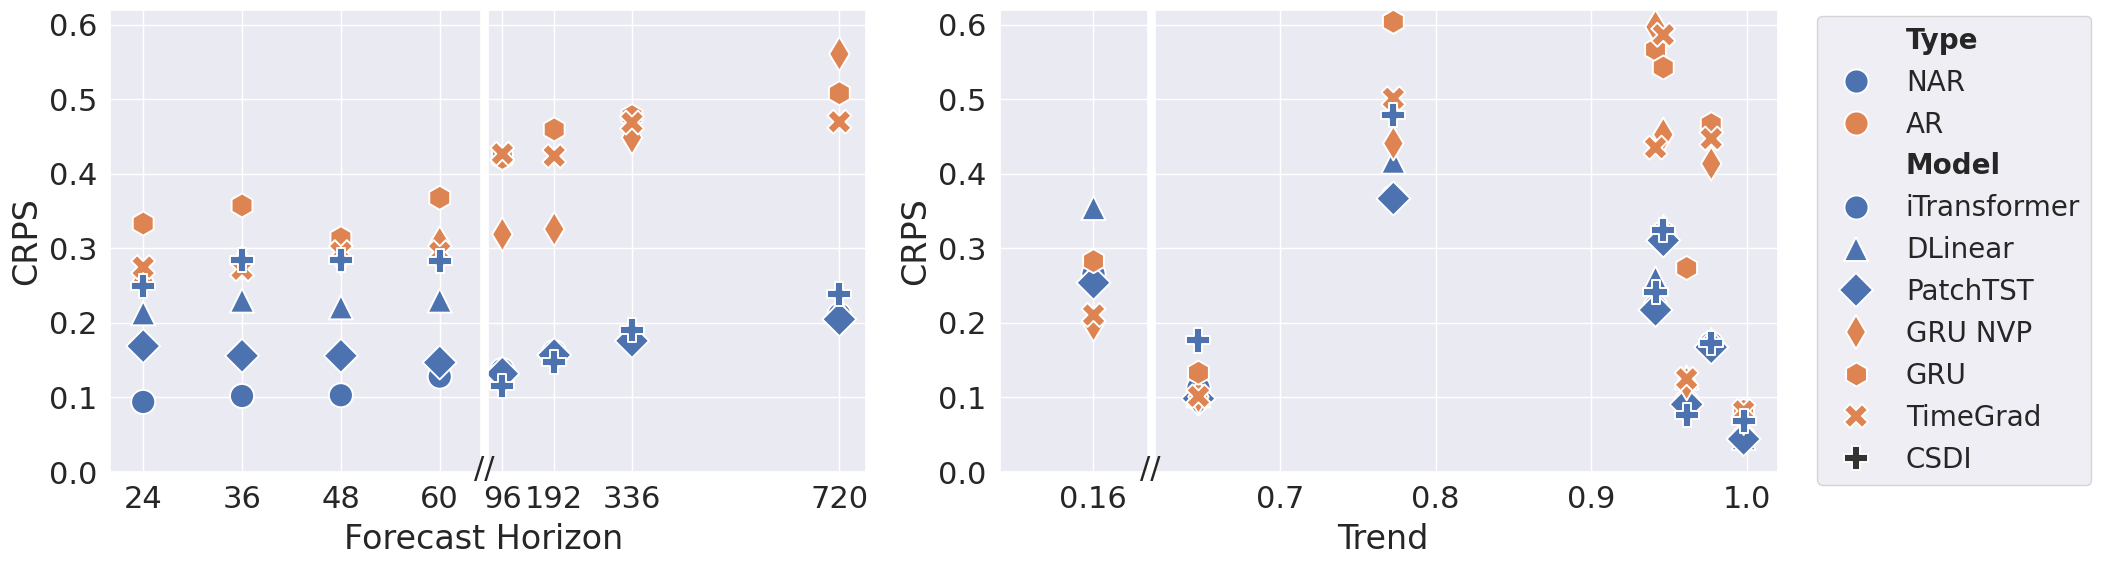

In [8]:
fig, (ax11, ax12, ax21, ax22) = plt.subplots(1, 4, figsize=(22, 6), gridspec_kw={'width_ratios':[1,1,0.4,1.6]})  # 调整大小

model_markers = ['o', '^', 'D', 'd', 'h', 'X', 'P'] 
# g = sns.scatterplot(data=df_horizon, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, palette=custom_palette, ax=ax1)

# 手动调整 ax11 和 ax12 位置，使它们更靠近
pos1 = ax11.get_position()  # 获取 ax11 的位置
pos2 = ax12.get_position()  # 获取 ax12 的位置

# 调整 ax11 和 ax12 的 x 位置
ax11.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
ax12.set_position([pos1.x0 + pos1.width * 1.02, pos2.y0, pos2.width * 1.02, pos2.height])

# 绘制第一个区间：0-100
sns.scatterplot(data=df_horizon, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                style="Model", s=300, palette=custom_palette, ax=ax11)

ax11.set_xlim(20, 65)
ax11.set_ylim(0, 0.62)
ax11.set_xticks([24, 36, 48, 60])

# 在 ax11 和 ax12 之间添加分割符号 "//"
fig.text((pos1.x1 + pos2.x0)/2 - 0.0155, pos1.y0 - 0.02, '//', ha='center', va='bottom', fontsize=22)

# 绘制第二个区间：100-720
sns.scatterplot(data=df_horizon[df_horizon['Forecasting Horizon'] > 75], x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                style="Model", s=300, palette=custom_palette, ax=ax12)

ax12.set_xlim(70, 770)
ax12.set_ylim(0, 0.62)
ax12.set_xticks([96, 192, 336, 720])

ax11.legend().remove()
ax12.legend().remove()
# remove y-axis label
ax12.set_ylabel('')
ax12.set_yticklabels([])

# 删除 ax12 的 x 轴标签（因为我们要在中间添加一个居中的标签）
ax12.set_xlabel('')
ax11.set_xlabel('')
fig.text((pos1.x1 + pos2.x0)/2 - 0.0155, pos1.y0 - 0.14, 'Forecast Horizon', ha='center', va='bottom', fontsize=24)

# plt.subplots_adjust(wspace=0.05)

# g.set_ylim(0, 0.62)
# g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# g.legend().remove()
# plt.show()
# plt.savefig('./fig/crps_predlen_wo_legend.pdf',bbox_inches = 'tight')

season = []
trend = []
crps=[]
models=[]
type=[]
datasets = []
pred_len=[]
norm_crps = []
# df_norm = long_crps  / long_crps.std()
model_list = ['iTransformer', 'DLinear','PatchTST','GRU NVP','GRU','TimeGrad','CSDI']

long_nmae.replace('-', np.nan, inplace=True)
long_nmae = long_nmae.apply(pd.to_numeric, errors='ignore')
long_nmae = long_nmae.groupby(['Model'])
long_nmae = long_nmae.agg(['mean']).reset_index()  
long_nmae.columns = long_nmae.columns.droplevel(1)
 
long_crps.replace('-', np.nan, inplace=True)
long_crps = long_crps.apply(pd.to_numeric, errors='ignore')
long_crps = long_crps.groupby(['Model'])
long_crps = long_crps.agg(['mean']).reset_index()  
long_crps.columns = long_crps.columns.droplevel(1)

for model in model_list:
    for idx in long_crps.index:
        if long_crps['pred_len'][idx] in [96,192,336]:
            dataset = long_crps['Model'][idx]
            season.append(data_char.loc['Seasonality'][dataset+'-L'])
            trend.append(data_char.loc['Trend'][dataset+'-L'])
            crps.append(long_crps[model][idx])
            norm_crps.append(df_norm[model][idx])
            models.append(model)
            type.append(auto_dict[model])
            datasets.append(dataset)
            pred_len.append(long_crps['pred_len'][idx])
        

df = {'Trend': trend, 'Seasonality': season, 'CRPS': crps, 'Model': models, 'Type': type, 'dataset': datasets, 'pred_len':pred_len, 'norm_crps': norm_crps}
df = pd.DataFrame(df)

# 获取unique的数据集及其对应的trend
unique_trends = df[['Trend', 'dataset']].drop_duplicates().reset_index(drop=True)
unique_trends = unique_trends.sort_values(by='Trend')
unique_trends['Trend Order'] = range(len(unique_trends))

# 创建一个偏移量字典，用于不同的Model
model_offset = {
    'CSDI': -0.2,
    'TimeGrad': -0.15,
    'Trans MAF': -0.1,
    'GRU MAF': -0.05,
    'GRU NVP': -0.1,
    'iTransformer': +0.2,
    'TimesNet': +0.15,
    'PatchTST': 0.05,
    'DLinear': +0.1,
    'NLinear': +0.2,
    'N-HiTS': +0.2
}

ch = 'Trend'

# g = sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax2)


# 手动调整 ax11 和 ax12 位置，使它们更靠近
pos1 = ax21.get_position()  # 获取 ax11 的位置
pos2 = ax22.get_position()  # 获取 ax12 的位置

# 调整 ax11 和 ax12 的 x 位置
ax21.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
ax22.set_position([pos1.x0 + pos1.width * 1.05, pos2.y0, pos2.width * 1.05, pos2.height])

# 绘制第一个区间：0-100
sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax21)

ax21.set_xlim(0.1, 0.2)
ax21.set_ylim(0, 0.62)
ax21.set_xticks([0.163])
ax21.set_xticklabels(['0.16'])

# 在 ax11 和 ax12 之间添加分割符号 "//"
fig.text((pos1.x1 + pos2.x0)/2 - 0.016, pos1.y0 - 0.02, '//', ha='center', va='bottom', fontsize=22)

# 绘制第二个区间：100-720
sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax22)

ax22.set_xlim(0.62, 1.02)
ax22.set_ylim(0, 0.62)
# ax22.set_xticks([96, 192, 336, 720])

ax21.legend().remove()
ax22.legend().remove()
# remove y-axis label
ax22.set_ylabel('')
ax22.set_yticklabels([])

# 删除 ax12 的 x 轴标签（因为我们要在中间添加一个居中的标签）
ax22.set_xlabel('')
ax21.set_xlabel('')
fig.text((pos1.x1 + pos2.x0)/2 + 0.09, pos1.y0 - 0.14, 'Trend', ha='center', va='bottom', fontsize=24)

hdls, labels = plt.gca().get_legend_handles_labels()
for i in range(4, 7):
    hdls[i].set_markerfacecolor(custom_palette['NAR'])
for i in range(7, 10):
    hdls[i].set_markerfacecolor(custom_palette['AR'])

legend = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.48), fontsize=20)
for t in legend.get_texts():
    if t.get_text() in ['Type', 'Model']:
        t.set_weight('bold')
# legend.get_frame().set_facecolor('white')

# 保存图像
plt.savefig('./fig/crps_horizon_and_trend_0814.pdf', bbox_inches='tight')

# 显示图像
plt.show()

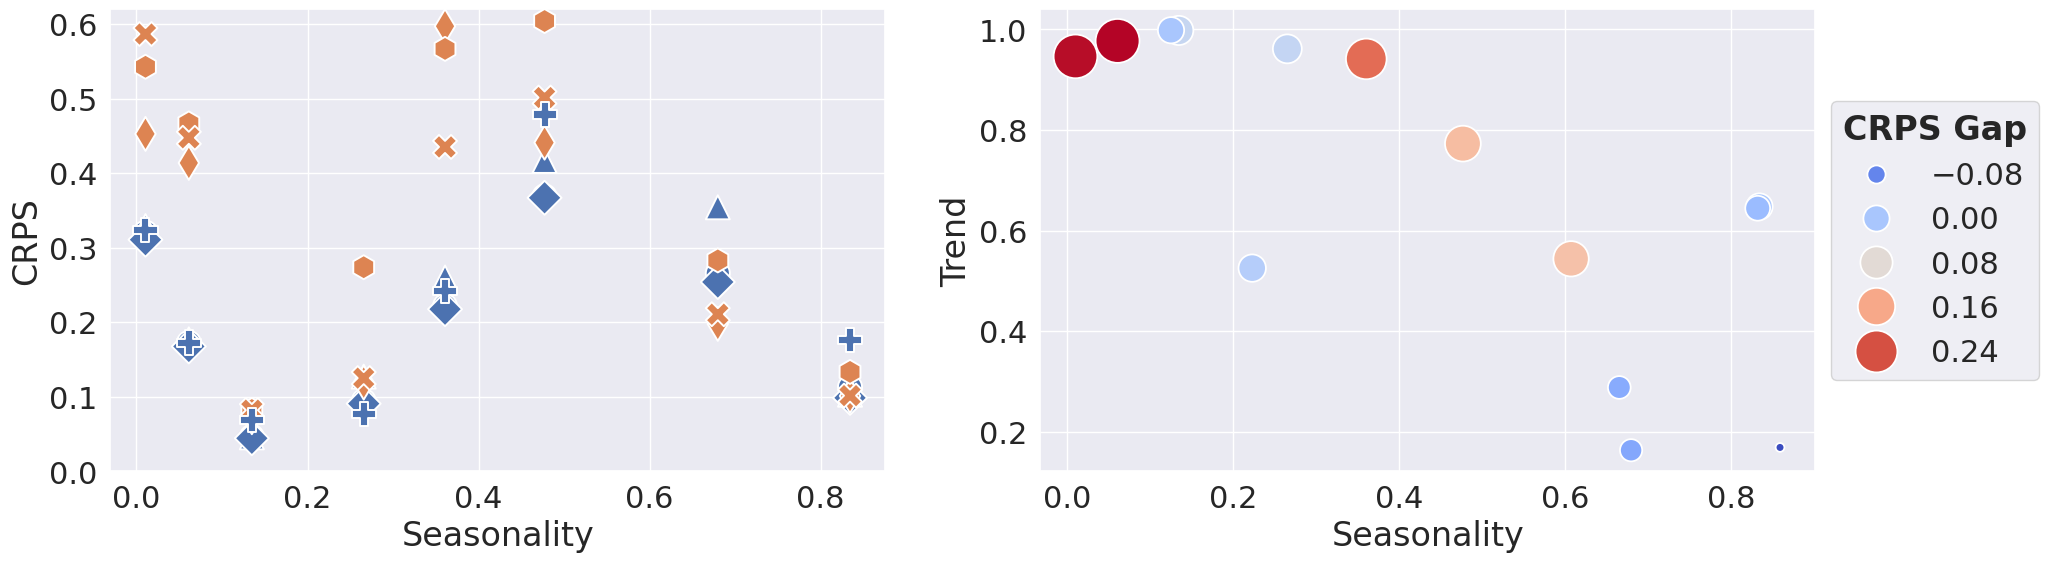

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))  # 调整大小

ch = 'Seasonality'
# plt.figure(figsize=(8,5) ) #,dpi=300)
g = sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax1)
g.set_ylim(0, 0.62)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
g.legend().remove()

season = []
trend = []
crps=[]
models=[]
type=[]
datasets = []
pred_len=[]
norm_crps = []
# df_norm = long_crps  / long_crps.std()
# long_crps = long_crps  / long_crps.std()
model_list = ['iTransformer', 'DLinear','PatchTST','GRU NVP','GRU','TimeGrad','CSDI']
# df_norm = long_crps[model_list]  / long_crps[model_list].std()
df_norm = long_crps[model_list]
crps_gap_dict = {}

for model in ['PatchTST']:
    for idx in long_crps.index:
        # if long_crps['pred_len'][idx] in [336]:
        dataset = long_crps['Model'][idx]
        crps_gap = long_crps['TimeGrad'][idx] - long_crps[model][idx]

        if dataset in crps_gap_dict:
            crps_gap_dict[dataset].append(crps_gap)
        else:
            crps_gap_dict.update({dataset: [crps_gap]})

        # season.append(data_char.loc['Seasonality'][dataset+'-L'])
        # trend.append(data_char.loc['Trend'][dataset+'-L'])
        # crps.append(crps_gap)
        # # norm_crps.append(df_norm[model][idx])
        # models.append(model)
        # type.append(auto_dict[model])
        # datasets.append(dataset)
        # pred_len.append(long_crps['pred_len'][idx])

for dataset in crps_gap_dict:
    season.append(data_char.loc['Seasonality'][dataset+'-L'])
    trend.append(data_char.loc['Trend'][dataset+'-L'])
    crps.append(np.mean(crps_gap_dict[dataset]))
    datasets.append(dataset)


for dataset in short_crps.columns:
    for model in ['PatchTST']:
        season.append(data_char.loc['Seasonality'][dataset+'-S'])
        trend.append(data_char.loc['Trend'][dataset+'-S'])
        crps.append(short_crps[dataset]['TimeGrad'] - short_crps[dataset][model])
        # norm_crps.append(df_norm[model][idx])
        # models.append(model)
        # type.append(auto_dict[model])
        datasets.append(dataset)
        # pred_len.append(24)


# df = {'Trend': trend, 'Seasonality': season, 'CRPS Gap': crps, 'Model': models, 'Type': type, 'dataset': datasets, 'pred_len':pred_len} #, 'norm_crps': norm_crps}
df = {'Trend': trend, 'Seasonality': season, 'CRPS Gap': crps, 'dataset': datasets}
df = pd.DataFrame(df)

# plt.figure(figsize=(7,5))
# palette = sns.color_palette("coolwarm", as_cmap=False)
g = sns.scatterplot(data=df, x='Seasonality', y='Trend', hue="CRPS Gap", size="CRPS Gap", palette="coolwarm", sizes=(40, 1000),ax=ax2)
lg = g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1,title='CRPS Gap')
# set title bold
plt.setp(lg.get_title(), fontweight='bold')
# lg.get_frame().set_facecolor('white')

# plt.show()
plt.savefig('./fig/crps_seasonality_0814.pdf',bbox_inches = 'tight')
